# Northwinds Database Business Needs

## Purpose 
The purpose of this notebook is to demostrate the useage of SQL to meet business needs. Below is list of business requirements and demonstrations of how those business requirements can be analyzed or met using SQL queries of the pertaining dataset. The data being used is not a real dataset, it is a sample dataset that can be used as a symbol of real business needs.


## Tools & Methodology 
*  Jupyter Notebook
*  SQL
*  Python (Libraries: ipython-sql, sqlalchemy)
*  Northwinds database (https://github.com/jpwhite3/northwind-SQLite3?tab=readme-ov-file)

## Database

The database being used is a sample database developed by Microsoft. The Northwind database contains the samples sales data for a fictitious company called “Northwind Traders,” which specliazes in the imports and exports specialty food. The database is highly detailed containing customer information who ordered the products; customer demographic information; product information and quantities; related supplier information for the products; etc. The richness of the dataset serves as example for  the actual complexities exhibited in real databases.

This dataset serves as an example for actual business data, and therefore can be used as a sample to answer real world business problems. The Northwinds database structure is standard for many usiness; purchases, employees, customer information; these are all datatypes common to businesses. Thus the North Winds database is an example of a business, that has real business questions that can be answered using data analytics and querying. This logic can be applied to any business in question that has similar needs.

## Database Schema
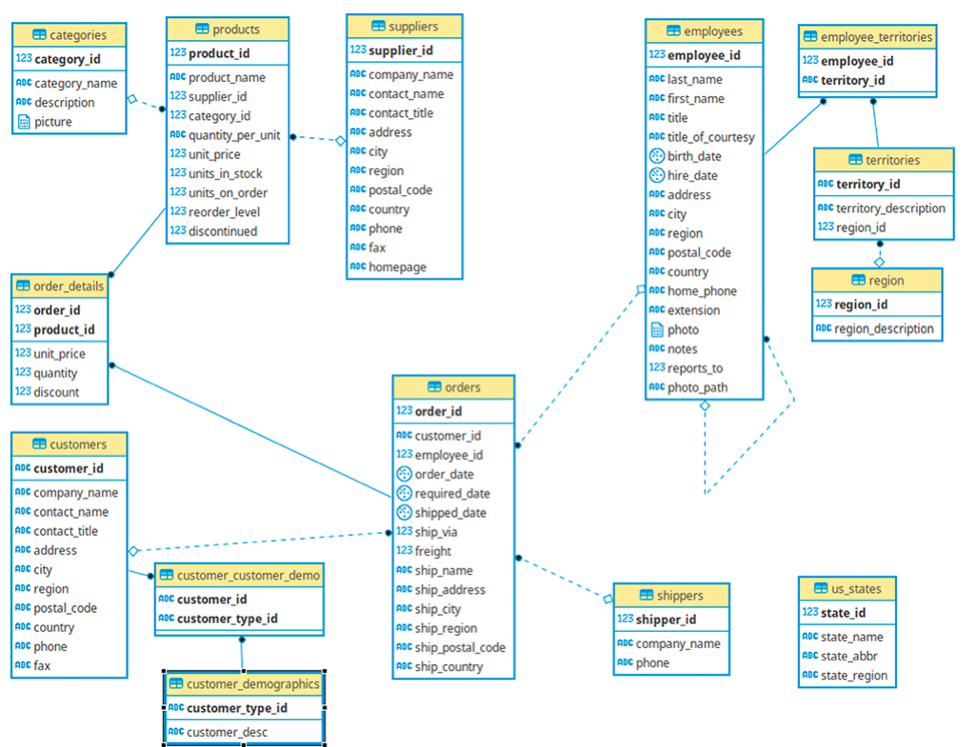
Image Source: https://docs.yugabyte.com/preview/sample-data/northwind/

## Code
### i) Import Packages

Starting off with importing packages necessary to run SQL and visualize it in JupyterNotebooks.
The database is saved on my server and will be accessed by utilizing these packages

In [1]:
import sqlite3
import pandas as pd

### ii) Connect to Database
Next we will connect to the database saved on my computer using these packages

In [2]:
#setting the path to the server
db_path = '/Users/shaydamaher/Documents/northwind.db'

#connect to database
sql_conn = sqlite3.connect(db_path)
cursor = sql_conn.cursor()

## a) Overstock Product
Nothing could be more detrimential to the customer experience then to have to wait to recieve your order due to the item being out of stock. Therefore lets identify the products that are backordered, these would theoretically be essential to address.

In [3]:
overstock_products = """
SELECT 
    p.ProductID, 
    p.ProductName, 
    p.UnitsInStock, 
    SUM(od.Quantity) AS TotalOrdered
FROM 
    Products p
JOIN 
    [Order Details] od ON p.ProductID = od.ProductID
WHERE 
    p.UnitsInStock = 0
GROUP BY 
    p.ProductID, 
    p.ProductName, 
    p.UnitsInStock
HAVING 
    TotalOrdered > 0
ORDER BY 
    TotalOrdered DESC;

"""

products = pd.read_sql_query(overstock_products, sql_conn)
products.head()

,ProductID,ProductName,UnitsInStock,TotalOrdered
0,31,Gorgonzola Telino,0,203616
1,17,Alice Mutton,0,202304
2,53,Perth Pasties,0,200146
3,5,Chef Anton's Gumbo Mix,0,199627
4,29,Thüringer Rostbratwurst,0,199010


## b) Popular Products with Low Stock
In the same breadth, not being to order products due to low inventory is as equally harmful to the customer experience. 

In [4]:
pop_products_low_stock = """
SELECT 
    p.ProductID, 
    p.ProductName, 
    p.UnitsInStock, 
    SUM(od.Quantity) AS TotalOrdered
FROM 
    Products p
JOIN 
    [Order Details] od ON p.ProductID = od.ProductID
WHERE 
    p.UnitsInStock = 0
GROUP BY 
    p.ProductID, 
    p.ProductName, 
    p.UnitsInStock
HAVING 
    TotalOrdered > 0
ORDER BY 
    TotalOrdered DESC;

"""

products = pd.read_sql_query(pop_products_low_stock, sql_conn)
products.head()

,ProductID,ProductName,UnitsInStock,TotalOrdered
0,31,Gorgonzola Telino,0,203616
1,17,Alice Mutton,0,202304
2,53,Perth Pasties,0,200146
3,5,Chef Anton's Gumbo Mix,0,199627
4,29,Thüringer Rostbratwurst,0,199010


## c) Reoccuring Orders Low Stock
One way to improve customer experience and honor reoccuring purchasers is to ensure their essential products are in stock. This query is to find reoccuring orders and ensure those products are in stock.  This way Northwinds can ensure that they always have key items in stock so purchasers can know they can always rely on Northwinds to meet their purchasing needs.

In [5]:
reocc_low_stock = """
SELECT 
    od.ProductID,
    p.ProductName,
    c.CustomerID,
    COUNT(DISTINCT o.OrderID) AS RecurringOrders,
    p.UnitsInStock
FROM 
    [Order Details] od
JOIN 
    Orders o ON od.OrderID = o.OrderID
JOIN 
    Customers c ON o.CustomerID = c.CustomerID
JOIN 
    Products p ON od.ProductID = p.ProductID
WHERE 
    p.UnitsInStock < 10  -- Low stock threshold
GROUP BY 
    od.ProductID, 
    p.ProductName, 
    c.CustomerID, 
    p.UnitsInStock
HAVING 
    COUNT(DISTINCT o.OrderID) > 2  -- Recurring orders threshold (3 or more)
ORDER BY 
    RecurringOrders DESC;

"""

products = pd.read_sql_query(reocc_low_stock, sql_conn)
products.head()

,ProductID,ProductName,CustomerID,RecurringOrders,UnitsInStock
0,5,Chef Anton's Gumbo Mix,BSBEV,118,0
1,31,Gorgonzola Telino,BSBEV,117,0
2,66,Louisiana Hot Spiced Okra,BSBEV,111,4
3,32,Mascarpone Fabioli,PICCO,110,9
4,68,Scottish Longbreads,HUNGC,110,6


## d) Stock Not Selling
The opposite of stock that is performing well and selling, is stock that has not sold and will not be expected to be sold. Keeping excess products in stock that are not being sold is detremential to business operations since the business would have to store and maintain useless stock. In this query excess, unusable stock is identified, and would be potential candidates for discount or reduction.

In [7]:
unsold_stock = """
SELECT p.ProductID, 
       p.ProductName, 
       p.UnitsInStock, 
       p.UnitsOnOrder, 
       MAX(o.OrderDate) AS LastOrderDate
FROM Products p
LEFT JOIN "Order Details" od ON p.ProductID = od.ProductID
LEFT JOIN Orders o ON od.OrderID = o.OrderID
GROUP BY p.ProductID, p.ProductName, p.UnitsInStock, p.UnitsOnOrder
HAVING MAX(o.OrderDate) < DATE('now', '-1 year')
   OR MAX(o.OrderDate) IS NULL
ORDER BY p.ProductName;

"""

products = pd.read_sql_query(unsold_stock, sql_conn)
products.head()

,ProductID,ProductName,UnitsInStock,UnitsOnOrder,LastOrderDate
0,17,Alice Mutton,0,0,2023-10-27 18:17:38
1,3,Aniseed Syrup,13,70,2023-10-27 06:38:44
2,40,Boston Crab Meat,123,0,2023-10-28 00:09:48
3,60,Camembert Pierrot,19,0,2023-10-27 06:38:44
4,18,Carnarvon Tigers,42,0,2023-10-27 18:17:38


## e) Best Customers
Most companies have loyal customers, that purchase large amounts of items or stock. These customers can be the backbone of the business. Therefore it can be imprtant to identify who is the most grossing customers of a business. These may be great opportunities to develop and mainain a business relationship possibly by assigning a case manager.

In [8]:
best_cus = """
SELECT c.CustomerID, 
       c.CompanyName, 
       SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS TotalGrossRevenue
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN "Order Details" od ON o.OrderID = od.OrderID
GROUP BY c.CustomerID, c.CompanyName
ORDER BY TotalGrossRevenue DESC;

"""

customers = pd.read_sql_query(best_cus, sql_conn)
customers.head()

,CustomerID,CompanyName,TotalGrossRevenue
0,BSBEV,B's Beverages,6154115.340
1,HUNGC,Hungry Coyote Import Store,5698023.670
2,RANCH,Rancho grande,5559110.080
3,GOURL,Gourmet Lanchonetes,5552309.805
4,ANATR,Ana Trujillo Emparedados y helados,5534356.650


## f) Best Employee
Another aspect of running a business is maintaining employee engagement, one way to do this is to reward employees that are high performers. For example in this case the highest performing employees could be classified as the employees that generate the most sales. These employees could be contenders to a bonus or another type of reward by the agency to encourage employee enagagement.

In [9]:
best_emp = """
SELECT e.EmployeeID, 
       e.FirstName || ' ' || e.LastName AS EmployeeName, 
       SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS TotalGrossSales
FROM Employees e
JOIN Orders o ON e.EmployeeID = o.EmployeeID
JOIN "Order Details" od ON o.OrderID = od.OrderID
GROUP BY e.EmployeeID, e.FirstName, e.LastName
ORDER BY TotalGrossSales DESC;

"""

employee = pd.read_sql_query(best_emp, sql_conn)
employee.head()

,EmployeeID,EmployeeName,TotalGrossSales
0,4,Margaret Peacock,5.148840e+07
1,5,Steven Buchanan,5.138646e+07
2,3,Janet Leverling,5.044557e+07
3,1,Nancy Davolio,4.965942e+07
4,7,Robert King,4.965190e+07


## g) Highest Grossing Supplier
It can be helpful to identify what suppliers are most impactful on sales. This information could be used to predict any potential issues with supply chain that will impact sales or to negotiate lower sales rate by unit.

In [10]:
high_gross_supplier = """
SELECT s.SupplierID, 
       s.CompanyName AS SupplierName, 
       SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS TotalGrossSales
FROM Suppliers s
JOIN Products p ON s.SupplierID = p.SupplierID
JOIN "Order Details" od ON p.ProductID = od.ProductID
GROUP BY s.SupplierID, s.CompanyName
ORDER BY TotalGrossSales DESC;

"""

supplier = pd.read_sql_query(high_gross_supplier, sql_conn)
supplier.head()

,SupplierID,SupplierName,TotalGrossSales
0,18,Aux joyeux ecclésiastiques,5.690022e+07
1,12,Plutzer Lebensmittelgroßmärkte AG,4.474509e+07
2,7,"Pavlova, Ltd.",3.588586e+07
3,4,Tokyo Traders,2.768235e+07
4,8,"Specialty Biscuits, Ltd.",2.309830e+07


## Conclusion
In order to ensure a high quality customer experience it is essential to ensure the business needs meet the desires of the customer, some basic data analysis can be conducted to ensure this. In this case a specialty product store can provide a high quality customer experience by ensuring that desireable products are in appropiate stocks and can always be reliably in stock. Also to ensure business needs continue to be met and exceeded it can also be important to have an understanding of the highest grossing suppliers, employees, and products.

## Next Steps
The next steps I would take in this hypothetical analysis is to collect information on the supply chain for essential products. This information could ensure that we can anticipate delays in product restock and be able to brainstorm on possible solutions before we have a product out of stock and are unable to reorder. 